# Notebook 3: Agentic RAG Pipeline

**Objectives:**
- Build 2-agent system using LangGraph (Retrieval Agent + Response Agent)
- Create FastAPI backend with `/recommend` endpoint
- Implement LangSmith logging for observability
- Test end-to-end functionality

**✅✅✅ Simplified Architecture:**
- **Agent 1 (Retrieval):** Extracts filters → Searches Qdrant → Returns events
- **Agent 2 (Response):** Formats events → Returns natural language response
- **Linear flow:** No complex conditional logic needed

---


## Setup & Imports


In [1]:
# Install required packages if needed
# !pip install langchain langgraph langsmith openai fastapi uvicorn pydantic


In [2]:
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Any, TypedDict
from dotenv import load_dotenv

# LangChain imports
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END

# Add backend to path for imports
sys.path.append(str(Path("..").resolve()))
from backend.vector_store import VectorStore

# Load environment variables
load_dotenv()

# Configure LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "nyc-event-recommender"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

print("✅ Imports successful!")
print(f"OpenAI API Key: {'✓' if os.getenv('OPENAI_API_KEY') else '✗'}")
print(f"LangSmith API Key: {'✓' if os.getenv('LANGCHAIN_API_KEY') else '✗'}")
print(f"LangSmith Tracing: {'Enabled' if os.getenv('LANGCHAIN_TRACING_V2') == 'true' else 'Disabled'}")


✅ Imports successful!
OpenAI API Key: ✓
LangSmith API Key: ✓
LangSmith Tracing: Enabled


## 1. Agent Architecture Design

**✅✅✅ 2-Agent System Overview:**

```
┌─────────────┐
│ User Query  │
└──────┬──────┘
       │
       ▼
┌─────────────────────────────┐
│  RETRIEVAL AGENT            │
│  - Extract filters from     │
│    query (baby_friendly,    │
│    price, category, etc.)   │
│  - Embed query              │
│  - Search Qdrant            │
│  - Return top-K events      │
└──────┬──────────────────────┘
       │
       ▼
┌─────────────────────────────┐
│  RESPONSE AGENT             │
│  - Format events naturally  │
│  - Highlight key details    │
│  - Return markdown response │
└──────┬──────────────────────┘
       │
       ▼
┌─────────────┐
│   Output    │
└─────────────┘
```

**Why 2 Agents?**
- **Separation of concerns:** Retrieval logic vs. formatting logic
- **Easier to debug:** Can test each agent independently
- **Faster:** No complex routing or conditional logic
- **Sufficient:** Semantic search handles nuance; no need for query planning agent

**Agentic Reasoning:**
- **Retrieval Agent:** Uses LLM to intelligently extract filters from natural language
- **Response Agent:** Uses LLM to format output conversationally

---


## 2. Define State Schema


In [3]:
class AgentState(TypedDict):
    """State passed between agents in the pipeline."""
    query: str                          # Original user query
    filters: Dict[str, Any]             # Extracted metadata filters
    retrieved_events: List[Dict]        # Events from Qdrant
    response: str                       # Final formatted response
    
print("✅ State schema defined!")


✅ State schema defined!


## 3. Agent 1: Retrieval Agent

**Responsibilities:**
1. Extract metadata filters from query (baby_friendly, price, etc.)
2. Embed the query
3. Search Qdrant with semantic search + filters
4. Return top-K relevant events


In [ ]:
# Initialize components
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
vector_store = VectorStore(path="../local_qdrant")

def retrieval_agent(state: AgentState) -> AgentState:
    """
    Agent 1: Extract filters and retrieve relevant events.
    """
    query = state["query"]
    
    # Step 1: Extract filters using LLM
    filter_prompt = f"""Given this user query about NYC events, extract any explicit filters.

Query: "{query}"

Return JSON with these optional filters:
- baby_friendly: true/false (if query mentions babies, infants, toddlers, strollers, kids, family-friendly)
- is_free: true (only if query explicitly mentions free)
- indoor_or_outdoor: "indoor" | "outdoor" | "both" (if query mentions location type)
  * "indoor" for museums, theaters, indoor venues
  * "outdoor" for parks, outdoor festivals, street events
  * "both" for flexible or mixed indoor/outdoor activities

If a filter is not mentioned, omit it from the JSON.

Examples:
- "baby-friendly museum" → {{"baby_friendly": true}}
- "free outdoor event" → {{"is_free": true, "indoor_or_outdoor": "outdoor"}}
- "romantic date night" → {{}}
- "stroller-accessible park" → {{"baby_friendly": true, "indoor_or_outdoor": "outdoor"}}
- "indoor activities for kids" → {{"baby_friendly": true, "indoor_or_outdoor": "indoor"}}
- "free museum" → {{"is_free": true, "indoor_or_outdoor": "indoor"}}

Return ONLY valid JSON, no explanations."""

    try:
        filter_response = llm.invoke([
            SystemMessage(content="You extract metadata filters from user queries. Always return valid JSON."),
            HumanMessage(content=filter_prompt)
        ])
        
        filters = json.loads(filter_response.content)
        print(f"🔍 Extracted filters: {filters}")
    except Exception as e:
        print(f"⚠️  Filter extraction failed: {e}. Using no filters.")
        filters = {}
    
    # Step 2: Search vector store
    search_results = vector_store.search_events(
        query=query,
        top_k=10,
        filters=filters if filters else None
    )
    
    print(f"✅ Retrieved {len(search_results)} events")
    
    # Update state
    state["filters"] = filters
    state["retrieved_events"] = search_results
    
    return state

print("✅ Retrieval Agent defined!")


✅ Retrieval Agent defined!


## 4. Agent 2: Response Agent

**Responsibilities:**
1. Take retrieved events
2. Format them naturally using GPT-4
3. Highlight key details (title, description, baby-friendliness, URL)
4. Return markdown-formatted response


In [5]:
def response_agent(state: AgentState) -> AgentState:
    """
    Agent 2: Format retrieved events into natural language response.
    """
    query = state["query"]
    events = state["retrieved_events"]
    
    if not events:
        state["response"] = "I couldn't find any events matching your criteria. Try broadening your search!"
        return state
    
    # Prepare event context for LLM
    event_context = ""
    for i, result in enumerate(events[:5], 1):  # Top 5 events
        event = result["event"]
        score = result["score"]
        event_context += f"""
Event {i}:
- Title: {event['title']}
- Description: {event['description'][:200]}...
- Baby-Friendly: {'Yes' if event['baby_friendly'] else 'No'}
- URL: {event['url']}
- Relevance Score: {score:.2f}

"""
    
    # Generate response
    response_prompt = f"""You are a helpful NYC event recommender assistant.

User Query: "{query}"

Here are the top events I found:
{event_context}

Task: Write a friendly, conversational response recommending these events. Include:
1. A brief intro acknowledging their query
2. Top 3-5 events with titles, brief descriptions, and key details
3. Mention if events are baby-friendly when relevant
4. Include URLs for more info
5. End with an encouraging note

Format in markdown. Be enthusiastic but concise!"""

    response_message = llm.invoke([
        SystemMessage(content="You are a friendly NYC event recommendation assistant. Be helpful and enthusiastic!"),
        HumanMessage(content=response_prompt)
    ])
    
    state["response"] = response_message.content
    print("✅ Response generated!")
    
    return state

print("✅ Response Agent defined!")


✅ Response Agent defined!


## 5. Build LangGraph Pipeline

Connect the two agents in a linear flow with LangSmith tracing.


In [6]:
# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retrieval", retrieval_agent)
workflow.add_node("response", response_agent)

# Define edges (linear flow)
workflow.set_entry_point("retrieval")
workflow.add_edge("retrieval", "response")
workflow.add_edge("response", END)

# Compile the graph
app = workflow.compile()

print("✅ LangGraph pipeline compiled!")
print("\nPipeline flow: retrieval → response → END")


✅ LangGraph pipeline compiled!

Pipeline flow: retrieval → response → END



PIPELINE VISUALIZATION

    START
      ↓
┌─────────────────┐
│  retrieval      │ ← Agent 1: Extract filters & search Qdrant
└────────┬────────┘
         ↓
┌─────────────────┐
│  response       │ ← Agent 2: Format events into response
└────────┬────────┘
         ↓
       END

Nodes: 2 agents
Edges: Linear (no conditional routing)
State Flow: query → filters → retrieved_events → response
LangSmith Tracing: Enabled



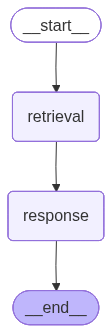

✅ Graph visualization above (if graphviz is installed)


In [7]:
# Visualize the pipeline
print("\n" + "="*60)
print("PIPELINE VISUALIZATION")
print("="*60)
print("""
    START
      ↓
┌─────────────────┐
│  retrieval      │ ← Agent 1: Extract filters & search Qdrant
└────────┬────────┘
         ↓
┌─────────────────┐
│  response       │ ← Agent 2: Format events into response
└────────┬────────┘
         ↓
       END

Nodes: 2 agents
Edges: Linear (no conditional routing)
State Flow: query → filters → retrieved_events → response
LangSmith Tracing: Enabled
""")

# Try to display the graph if graphviz is available
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
    print("✅ Graph visualization above (if graphviz is installed)")
except Exception as e:
    print(f"ℹ️  Graph visualization unavailable (install graphviz for visual graph): {type(e).__name__}")


## 6. Test the Pipeline

Test with multiple queries to verify end-to-end functionality.


In [8]:
def run_pipeline(query: str) -> str:
    """
    Run the agentic RAG pipeline end-to-end.
    """
    print(f"\n{'='*60}")
    print(f"QUERY: {query}")
    print(f"{'='*60}\n")
    
    initial_state = {
        "query": query,
        "filters": {},
        "retrieved_events": [],
        "response": ""
    }
    
    # Run the pipeline (with LangSmith tracing)
    final_state = app.invoke(initial_state)
    
    return final_state["response"]

print("✅ Pipeline runner defined!")


✅ Pipeline runner defined!


In [9]:
# Test 1: Baby-friendly query
from IPython.display import Markdown, display

query1 = "not free"
response1 = run_pipeline(query1)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response1))



QUERY: not free

🔍 Extracted filters: {'is_free': 'false'}
✅ Retrieved 0 events

RESPONSE:



I couldn't find any events matching your criteria. Try broadening your search!

In [16]:
# Test 2: Romantic/vibe query (semantic search shines here!)
query2 = "free"
response2 = run_pipeline(query2)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response2))



QUERY: free

🔍 Extracted filters: {'is_free': 'true'}
✅ Retrieved 0 events

RESPONSE:



I couldn't find any events matching your criteria. Try broadening your search!

In [11]:
# Test 3: High-energy activity
query3 = "High-energy outdoor activity with friends"
response3 = run_pipeline(query3)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response3))



QUERY: High-energy outdoor activity with friends

🔍 Extracted filters: {'indoor_or_outdoor': 'outdoor'}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Hey there! 🌟 It sounds like you're looking for some high-energy outdoor activities to enjoy with your friends in NYC! I've got some fantastic options for you that are sure to get the adrenaline pumping and create unforgettable memories. Check these out:

### 1. Latin Mix Saturdays
**Description:** Experience the ultimate Saturday night at Time Out Market’s Rooftop Latin Mix Party! Join resident DJ Torres and friends for an unforgettable evening filled with reggaetón, salsa, merengue, bachata, and Latin house music.  
**Baby-Friendly:** No  
**More Info:** [Latin Mix Saturdays](https://www.timeout.com/time-out-market-new-york/time-out-market/latin-mix-saturdays)

### 2. Friday Night Vibes at Time Out Market
**Description:** Kick off your weekend at Time Out Market New York’s stunning rooftop! Friday Night Vibes starts at 7 PM with DJ Stretch spinning tunes on the first and third Friday of each month.  
**Baby-Friendly:** No  
**More Info:** [Friday Night Vibes](https://www.timeout.com/newyork/things-to-do/rooftop-fridays-at-time-out-market)

### 3. Rooftop Cinema Club
**Description:** Take your movie night to new heights at the Rooftop Cinema Club! Enjoy stunning views and a fantastic lineup of films at a midtown skyscraper. It’s a unique way to enjoy cinema under the stars!  
**Baby-Friendly:** No  
**More Info:** [Rooftop Cinema Club](https://www.timeout.com/newyork/news/here-are-all-the-movies-coming-to-nycs-rooftop-cinema-club-this-summer-041525)

### 4. Smorgasburg
**Description:** Dive into the food bazaar spectacular at Smorgasburg! With dozens of local vendors, you can explore delicious bites across three locations: WTC on Fridays, Williamsburg on Saturdays, and Prospect Park on Sundays.  
**Baby-Friendly:** Yes  
**More Info:** [Smorgasburg](https://www.timeout.com/newyork/restaurants/smorgasburg-guide)

These events are perfect for a fun day or night out with friends! Enjoy the vibrant atmosphere and make some amazing memories. Have a blast! 🎉

In [12]:
# Test 4: Relaxing cultural event
query4 = "Relaxing cultural event for adults"
response4 = run_pipeline(query4)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response4))



QUERY: Relaxing cultural event for adults

🔍 Extracted filters: {}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Absolutely! I’d love to help you find a relaxing cultural event in NYC. Here are some fantastic options that you might enjoy:

### 1. Arte Museum
**Description:** Immerse yourself in a multi-sensory journey at the new Arte Museum! Experience digital art, evocative soundscapes, and custom-crafted scents that transport you beyond time and space.  
**Baby-Friendly:** Yes  
**More Info:** [Arte Museum](https://www.timeout.com/newyork/art/arte-museum)

---

### 2. The Other Art Fair Brooklyn
**Description:** Connect with artists and explore hundreds of original artworks across various media, including painting, photography, and immersive installations. It’s a great way to appreciate creativity in a relaxed setting!  
**Baby-Friendly:** Yes  
**More Info:** [The Other Art Fair Brooklyn](https://www.timeout.com/newyork/things-to-do/the-other-art-fair)

---

### 3. “Gardens of Renewal” by Lily Kwong
**Description:** Take a mental break at Madison Square Park with the meditative spiral pathway called "Gardens of Renewal." It’s a beautiful spot to unwind and enjoy nature!  
**Baby-Friendly:** Yes  
**More Info:** [Gardens of Renewal](https://www.timeout.com/newyork/news/a-meditative-garden-by-lily-kwong-has-taken-root-in-madison-square-park-042925)

---

These events offer a wonderful blend of relaxation and culture, perfect for adults looking to unwind. Enjoy your time exploring the vibrant art scene and beautiful spaces in NYC! If you have any more questions or need further recommendations, feel free to ask! 🌟

In [13]:
# Test 5: Kid-friendly museum
query5 = "outdoor"
response5 = run_pipeline(query5)

print("\n" + "="*60)
print("RESPONSE:")
print("="*60 + "\n")
display(Markdown(response5))



QUERY: outdoor

🔍 Extracted filters: {'indoor_or_outdoor': 'outdoor'}
✅ Retrieved 10 events
✅ Response generated!

RESPONSE:



Absolutely! I’m thrilled to help you find some fantastic outdoor events happening in NYC! Here are some top picks that you won’t want to miss:

### 1. Ai Weiwei's Camouflage
Dive into the world of art with Ai Weiwei's stunning new installation on Roosevelt Island! This monumental piece will be on display through December 1, marking his return to New York. It’s a unique experience you won’t want to miss!
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/news/a-new-ai-weiwei-installation-will-cover-roosevelt-island-in-camouflage-netting-042525)

### 2. Smorgasburg
Food lovers, rejoice! Smorgasburg is back with a spectacular food bazaar featuring dozens of local vendors. You can find it at three locations: WTC on Fridays, Williamsburg on Saturdays, and Prospect Park on Sundays. Perfect for a fun day out!
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/restaurants/smorgasburg-guide)

### 3. “Gardens of Renewal” by Lily Kwong
Need a little peace and tranquility? Head over to Madison Square Park to stroll through the beautiful "Gardens of Renewal." This meditative spiral pathway is designed to help you unwind and reconnect with nature.
- **Baby-Friendly:** Yes
- [More Info](https://www.timeout.com/newyork/news/a-meditative-garden-by-lily-kwong-has-taken-root-in-madison-square-park-042925)

### 4. Latin Mix Saturdays
If you’re in the mood for a lively night out, check out the Rooftop Latin Mix Party at Time Out Market! Dance the night away to reggaetón, salsa, and more with DJ Torres and friends. 
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/time-out-market-new-york/time-out-market/latin-mix-saturdays)

### 5. Friday Night Vibes at Time Out Market
Kick off your weekend with some great vibes at Time Out Market’s rooftop! Enjoy music from DJ Stretch and soak in the stunning views. It’s a perfect way to start your Friday night!
- **Baby-Friendly:** No
- [More Info](https://www.timeout.com/newyork/things-to-do/rooftop-fridays-at-time-out-market)

I hope you find something that excites you! Enjoy your time outdoors in the vibrant city of New York! 🌟

## 7. Create Backend Files

Now we'll create the production-ready backend files for FastAPI.


### 7.1 Create `backend/agents.py`


In [14]:
agents_code = '''"""Agentic RAG pipeline for NYC Event Recommender.

This module implements a 2-agent system:
1. Retrieval Agent: Extracts filters and retrieves relevant events
2. Response Agent: Formats events into natural language responses
"""

import os
import json
from typing import Dict, List, Any, TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END
from backend.vector_store import VectorStore


class AgentState(TypedDict):
    """State passed between agents in the pipeline."""
    query: str
    filters: Dict[str, Any]
    retrieved_events: List[Dict]
    response: str


class EventRecommenderPipeline:
    """2-agent RAG pipeline for event recommendations."""
    
    def __init__(self, qdrant_path: str = "./local_qdrant"):
        """Initialize the pipeline with LLM and vector store."""
        self.llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        self.vector_store = VectorStore(path=qdrant_path)
        self.app = self._build_graph()
    
    def retrieval_agent(self, state: AgentState) -> AgentState:
        """Agent 1: Extract filters and retrieve relevant events."""
        query = state["query"]
        
        # Extract filters using LLM
        filter_prompt = f"""Given this user query about NYC events, extract any explicit filters.

Query: "{query}"

Return JSON with these optional filters:
- baby_friendly: true/false (if query mentions babies, infants, toddlers, strollers, kids, family-friendly)
- is_free: true (only if query explicitly mentions free)
- indoor_or_outdoor: "indoor" | "outdoor" | "both" (if query mentions location type)
  * "indoor" for museums, theaters, indoor venues
  * "outdoor" for parks, outdoor festivals, street events
  * "both" for flexible or mixed indoor/outdoor activities

If a filter is not mentioned, omit it from the JSON.

Examples:
- "baby-friendly museum" → {{"baby_friendly": true}}
- "free outdoor event" → {{"is_free": true, "indoor_or_outdoor": "outdoor"}}
- "romantic date night" → {{}}
- "stroller-accessible park" → {{"baby_friendly": true, "indoor_or_outdoor": "outdoor"}}
- "indoor activities for kids" → {{"baby_friendly": true, "indoor_or_outdoor": "indoor"}}
- "free museum" → {{"is_free": true, "indoor_or_outdoor": "indoor"}}

Return ONLY valid JSON, no explanations."""

        try:
            filter_response = self.llm.invoke([
                SystemMessage(content="You extract metadata filters from user queries. Always return valid JSON."),
                HumanMessage(content=filter_prompt)
            ])
            filters = json.loads(filter_response.content)
        except Exception as e:
            print(f"Filter extraction failed: {e}")
            filters = {}
        
        # Search vector store
        search_results = self.vector_store.search_events(
            query=query,
            top_k=10,
            filters=filters if filters else None
        )
        
        state["filters"] = filters
        state["retrieved_events"] = search_results
        return state
    
    def response_agent(self, state: AgentState) -> AgentState:
        """Agent 2: Format retrieved events into natural language response."""
        query = state["query"]
        events = state["retrieved_events"]
        
        if not events:
            state["response"] = "I couldn't find any events matching your criteria. Try broadening your search!"
            return state
        
        # Prepare event context
        event_context = ""
        for i, result in enumerate(events[:5], 1):
            event = result["event"]
            score = result["score"]
            event_context += f"""
Event {i}:
- Title: {event['title']}
- Description: {event['description'][:200]}...
- Baby-Friendly: {'Yes' if event['baby_friendly'] else 'No'}
- URL: {event['url']}
- Relevance Score: {score:.2f}

"""
        
        # Generate response
        response_prompt = f"""You are a helpful NYC event recommender assistant.

User Query: "{query}"

Here are the top events I found:
{event_context}

Task: Write a friendly, conversational response recommending these events. Include:
1. A brief intro acknowledging their query
2. Top 3-5 events with titles, brief descriptions, and key details
3. Mention if events are baby-friendly when relevant
4. Include URLs for more info
5. End with an encouraging note

Format in markdown. Be enthusiastic but concise!"""

        response_message = self.llm.invoke([
            SystemMessage(content="You are a friendly NYC event recommendation assistant. Be helpful and enthusiastic!"),
            HumanMessage(content=response_prompt)
        ])
        
        state["response"] = response_message.content
        return state
    
    def _build_graph(self) -> StateGraph:
        """Build the LangGraph pipeline."""
        workflow = StateGraph(AgentState)
        
        # Add nodes
        workflow.add_node("retrieval", self.retrieval_agent)
        workflow.add_node("response", self.response_agent)
        
        # Define edges
        workflow.set_entry_point("retrieval")
        workflow.add_edge("retrieval", "response")
        workflow.add_edge("response", END)
        
        return workflow.compile()
    
    def run(self, query: str) -> Dict[str, Any]:
        """Run the pipeline end-to-end."""
        initial_state = {
            "query": query,
            "filters": {},
            "retrieved_events": [],
            "response": ""
        }
        
        final_state = self.app.invoke(initial_state)
        
        return {
            "query": query,
            "filters": final_state["filters"],
            "events": final_state["retrieved_events"],
            "response": final_state["response"]
        }
'''

# Write to file
backend_dir = Path("../backend")
agents_path = backend_dir / "agents.py"
agents_path.write_text(agents_code)

print(f"✅ Created {agents_path}")
print("\nModule includes:")
print("  - AgentState (TypedDict)")
print("  - EventRecommenderPipeline class")
print("  - retrieval_agent()")
print("  - response_agent()")
print("  - run() method for end-to-end execution")


✅ Created ../backend/agents.py

Module includes:
  - AgentState (TypedDict)
  - EventRecommenderPipeline class
  - retrieval_agent()
  - response_agent()
  - run() method for end-to-end execution


### 7.2 Create `backend/main.py` (FastAPI)


In [15]:
fastapi_code = '''"""FastAPI backend for NYC Event Recommender.

This module provides REST API endpoints for event recommendations
using the agentic RAG pipeline.
"""

import os
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv
from backend.agents import EventRecommenderPipeline

# Load environment variables
load_dotenv()

# Configure LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "nyc-event-recommender"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

# Initialize FastAPI app
app = FastAPI(
    title="NYC Event Recommender API",
    description="AI-powered event recommendation system for NYC",
    version="1.0.0"
)

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Initialize the pipeline
pipeline = EventRecommenderPipeline(qdrant_path="./local_qdrant")


class QueryRequest(BaseModel):
    """Request model for event recommendations."""
    query: str = Field(..., description="User query for event recommendations")
    top_k: Optional[int] = Field(5, description="Number of events to return", ge=1, le=20)


class QueryResponse(BaseModel):
    """Response model for event recommendations."""
    query: str
    filters: dict
    response: str
    num_events: int


@app.get("/")
def read_root():
    """Health check endpoint."""
    return {
        "message": "NYC Event Recommender API",
        "status": "online",
        "version": "1.0.0"
    }


@app.post("/recommend", response_model=QueryResponse)
def recommend_events(request: QueryRequest):
    """
    Get event recommendations based on user query.
    
    Args:
        request: QueryRequest with user query and optional top_k
    
    Returns:
        QueryResponse with recommendations and metadata
    """
    try:
        # Run the pipeline
        result = pipeline.run(request.query)
        
        return QueryResponse(
            query=result["query"],
            filters=result["filters"],
            response=result["response"],
            num_events=len(result["events"])
        )
    
    except Exception as e:
        raise HTTPException(
            status_code=500,
            detail=f"Error processing query: {str(e)}"
        )


@app.get("/health")
def health_check():
    """Detailed health check with component status."""
    return {
        "status": "healthy",
        "components": {
            "vector_store": "online",
            "llm": "online",
            "langgraph": "online"
        }
    }


if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Write to file
main_path = backend_dir / "main.py"
main_path.write_text(fastapi_code)

print(f"✅ Created {main_path}")
print("\nFastAPI endpoints:")
print("  - GET  /             → Health check")
print("  - POST /recommend    → Get event recommendations")
print("  - GET  /health       → Detailed health status")
print("\nTo start the server:")
print("  cd /path/to/project")
print("  uvicorn backend.main:app --reload")


✅ Created ../backend/main.py

FastAPI endpoints:
  - GET  /             → Health check
  - POST /recommend    → Get event recommendations
  - GET  /health       → Detailed health status

To start the server:
  cd /path/to/project
  uvicorn backend.main:app --reload
